In [1]:
using Random
using StatsBase
using Distributions
using StatsPlots
using StatsFuns
using Logging

using Turing
using CSV
using DataFrames
using Optim
using StatisticalRethinking

default(labels=false)
Logging.disable_logging(Logging.Warn);

# 9.1 Good King Markov and his island kingdom

Code 9.1

In [2]:
Random.seed!(1)
num_weeks = 10^5
positions = []
current = 10

for i ∈ 1:num_weeks
    # record current position
    push!(positions, current)
    # flip coin to generate proposal
    proposal = current + sample([-1, 1])
    # handle loops around
    proposal < 1 && (proposal = 10)
    proposal > 10 && (proposal = 1)
    # move?
    prob_move = proposal / current
    rand() < prob_move && (current = proposal)
end

Code 9.2

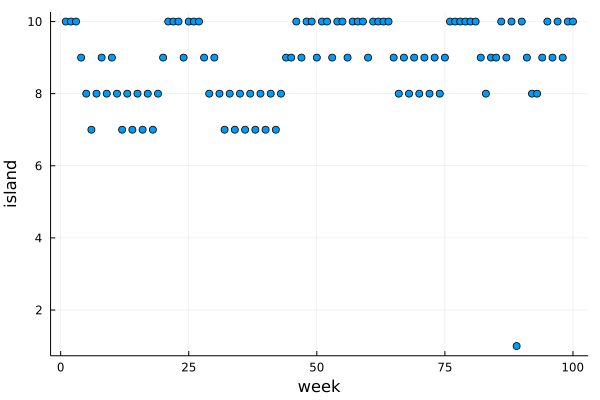

In [3]:
scatter(positions[1:100], xlab="week", ylab="island")

Code 9.3

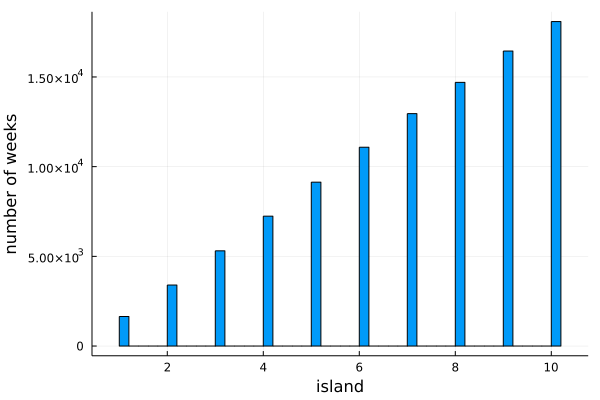

In [4]:
histogram(positions, xlab="island", ylab="number of weeks")

# 9.2 Metropolis algorithms

Code 9.4

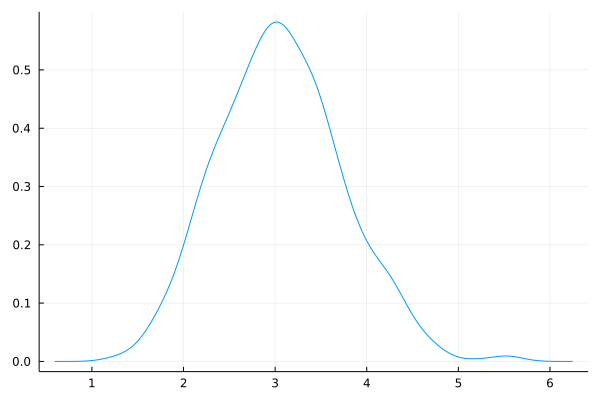

In [5]:
D = 10
T = 1000
Y = rand(MvNormal(zeros(D), ones(D)), T)
Rd = sqrt.(sum.(eachcol(Y.^2)))
density(Rd)

# 9.3 Hamiltonian Monte Carlo

Code 9.5

In [6]:
Random.seed!(7)

x = rand(Normal(), 50)
y = rand(Normal(), 50)
x = standardize(ZScoreTransform, x)
y = standardize(ZScoreTransform, y);

In [7]:
function U(q::Vector{Float64}; a=0, b=1, k=0, d=1)::Float64
    μy, μx = q
    U = sum(normlogpdf.(μy, 1, y)) + sum(normlogpdf.(μx, 1, x)) 
    U += normlogpdf(a, b, μy) + normlogpdf(k, d, μx)
    -U
end

U (generic function with 1 method)

Code 9.6

In [8]:
function ∇U(q::Vector{Float64}; a=0, b=1, k=0, d=1)::Vector{Float64}
    μy, μx = q
    G₁ = sum(y .- μy) + (a - μy) / b^2  # ∂U/∂μy
    G₂ = sum(x .- μx) + (k - μx) / d^2  # ∂U/∂μx
    [-G₁, -G₂]
end

∇U (generic function with 1 method)

Code 9.8, 9.9, 9.10 (before 9.7 to define HMC2 funcition)

In [9]:
function HMC2(U, ∇U, ϵ::Float64, L::Int, current_q::Vector{Float64})
    q = current_q
    p = rand(Normal(), length(q))  # random flick - p is momentum
    current_p = p
    
    # make a half step for momentum at the beginning
    p -= ϵ .* ∇U(q) ./ 2
    
    # initialize bookkeeping - saves trajectory
    qtraj = [q]
    ptraj = [p]
    
    # Alternate full steps for position and momentum
    for i ∈ 1:L
        q += @. ϵ * p  # full step for the position
        # make a full step for the momentum except at the end of trajectory
        if i != L
            p -= ϵ * ∇U(q)
            push!(ptraj, p)
        end
        push!(qtraj, q)
    end
    
    # Make a half step for momentum at the end
    p -= ϵ * ∇U(q) / 2
    push!(ptraj, p)
    
    # negate momentum at the end of trajectory to make the proposal symmetric
    p = -p
    
    # evaluate potential and kinetic energies at the start and the end of trajectory
    current_U = U(current_q)
    current_K = sum(current_p.^2)/2
    proposed_U = U(q)
    proposed_K = sum(p.^2)/2
    
    # accept or reject the state at the end of trajectory, returning either
    # the position at the end of the trajectory or the initial position
    accept = (rand() < exp(current_U - proposed_U + current_K - proposed_K))

    if accept
        current_q = q
    end
    
    (q=current_q, traj=qtraj, ptraj=ptraj, accept=accept)
end

HMC2 (generic function with 1 method)

Code 9.7

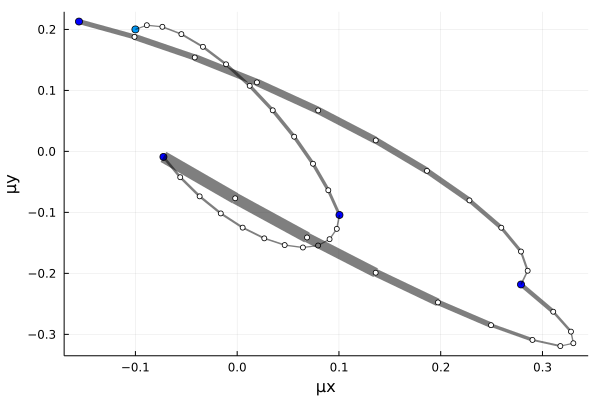

In [10]:
Random.seed!(1)
Q = (q=[-0.1, 0.2],)
pr = 0.3
step = 0.03
L = 11
n_samples = 4
p = scatter([Q.q[1]], [Q.q[2]], xlab="μx", ylab="μy")

for i ∈ 1:n_samples
    Q = HMC2(U, ∇U, step, L, Q.q)
    if n_samples < 10 
        cx, cy = [], []
        for j ∈ 1:L
            K0 = sum(Q.ptraj[j].^2)/2
            plot!(
                [Q.traj[j][1], Q.traj[j+1][1]],
                [Q.traj[j][2], Q.traj[j+1][2]],
                lw=1+2*K0,
                c=:black,
                alpha=0.5
            )
            push!(cx, Q.traj[j+1][1])
            push!(cy, Q.traj[j+1][2])
        end
        scatter!(cx, cy, c=:white, ms=3)
    end
    scatter!([Q.q[1]], [Q.q[2]], shape=(Q.accept ? :circle : :rect), c=:blue)
end
p

# 9.4 Easy HMC: ulam

Code 9.11

In [11]:
d = DataFrame(CSV.File("data/rugged.csv"))
dd = d[completecases(d, :rgdppc_2000),:]
dd[:,:log_gdp] = log.(dd.rgdppc_2000);
dd[:,:log_gdp_std] = dd.log_gdp / mean(dd.log_gdp)
dd[:,:rugged_std] = dd.rugged / maximum(dd.rugged)
dd[:,:cid] = @. ifelse(dd.cont_africa == 1, 1, 2);

Code 9.12

In [12]:
r̄ = mean(dd.rugged_std);

@model function model_m8_3(rugged_std, cid,  log_gdp_std)
    σ ~ Exponential()
    a ~ MvNormal([1, 1], 0.1)
    b ~ MvNormal([0, 0], 0.3)
    μ = @. a[cid] + b[cid] * (rugged_std - r̄)
    log_gdp_std ~ MvNormal(μ, σ)
end

m8_3 = optimize(model_m8_3(dd.rugged_std, dd.cid,  dd.log_gdp_std), MAP())
m8_3_df = DataFrame(sample(m8_3, 1000))
precis(m8_3_df)

┌───────┬─────────────────────────────────────────────────────────┐
│ param │    mean     std    5.5%      50%    94.5%     histogram │
├───────┼─────────────────────────────────────────────────────────┤
│  a[1] │  0.8868  0.0164  0.8599   0.8879   0.9112  ▁▁▁▂▄▇██▅▂▁▁ │
│  a[2] │  1.0504  0.0103  1.0338   1.0505   1.0671      ▁▁▄██▄▁▁ │
│  b[1] │  0.1341  0.0749  0.0108   0.1357   0.2519   ▁▁▃▅█▇▄▂▁▁▁ │
│  b[2] │ -0.1454  0.0534   -0.23  -0.1453  -0.0608       ▁▄██▄▁▁ │
│     σ │  0.1096  0.0059  0.0999   0.1098   0.1185     ▁▁▂▅██▄▁▁ │
└───────┴─────────────────────────────────────────────────────────┘


Code 9.13

For Turing this is not needed

In [13]:
dat_slim = dd[!,[:log_gdp_std, :rugged_std, :cid]]
describe(dat_slim)

3×7 DataFrame
 Row │ variable     mean     min          median    max      nmissing  eltype  ⋯
     │ Symbol       Float64  Real         Float64   Real     Int64     DataTyp ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ log_gdp_std  1.0      0.721556     1.00718   1.28736         0  Float64 ⋯
   2 │ rugged_std   0.21496  0.000483715  0.157933  1.0             0  Float64
   3 │ cid          1.71176  1            2.0       2               0  Int64
                                                                1 column omitted

Code 9.14

In [14]:
@model function model_m9_1(rugged_std, cid,  log_gdp_std)
    σ ~ Exponential()
    a ~ MvNormal([1, 1], 0.1)
    b ~ MvNormal([0, 0], 0.3)
    μ = @. a[cid] + b[cid] * (rugged_std - r̄)
    log_gdp_std ~ MvNormal(μ, σ)
end

# one chain will be produced by default
m9_1 = sample(model_m8_3(dd.rugged_std, dd.cid,  dd.log_gdp_std), NUTS(), 1000);

Code 9.15

In [15]:
precis(DataFrame(m9_1))

┌───────┬───────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%    94.5%      histogram │
├───────┼───────────────────────────────────────────────────────────┤
│  a[1] │  0.8865  0.0157   0.8606   0.8863    0.911    ▁▁▂▃▇██▅▂▁▁ │
│  a[2] │  1.0509  0.0097   1.0353   1.0512   1.0662  ▁▁▂▄▆██▆▅▂▁▁▁ │
│  b[1] │  0.1299  0.0708   0.0168   0.1311   0.2381    ▁▁▂▃▇██▄▁▁▁ │
│  b[2] │ -0.1424  0.0557  -0.2309  -0.1428  -0.0524      ▁▁▃██▅▂▁▁ │
│     σ │  0.1117  0.0066    0.102   0.1114   0.1227     ▁▁▄▇█▅▃▁▁▁ │
└───────┴───────────────────────────────────────────────────────────┘


Code 9.16

For this to use multiple cores, julia has to be started with `--threads 4` parameter, otherwise chains will be sampled sequentially

In [34]:
m9_1 = sample(model_m8_3(dd.rugged_std, dd.cid,  dd.log_gdp_std), NUTS(), MCMCThreads(), 250, 4);

Code 9.17

This shows combined chains statistics. To get information about individual chains, use `m9_1[:,:,1]`

In [35]:
m9_1

Chains MCMC chain (250×17×4 Array{Float64, 3}):

Iterations        = 126:1:375
Number of chains  = 4
Samples per chain = 250
Wall duration     = 0.4 seconds
Compute duration  = 0.4 seconds
parameters        = σ, a[1], a[2], b[1], b[2]
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

           σ    0.1118    0.0063     0.0002    0.0002    915.8204    1.0022    ⋯
        a[1]    0.8867    0.0169     0.0005    0.0004   1283.9585    0.9994    ⋯
        a[2]    1.0500    0.0100     0.0003    0.0003   1050.1501    0.9982    ⋯
        b[1]    0.1340    0.0766     0.0024    0.0030    618.3719    1.0020    ⋯
        b[2]   -0.1409    0.0561     0.0018    0.0020 

Code 9.18

In [36]:
precis(DataFrame(m9_1[:,:,1:2]))

┌───────┬────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%   94.5%    histogram │
├───────┼────────────────────────────────────────────────────────┤
│  a[1] │  0.8867  0.0171   0.8614   0.8859   0.915  ▁▁▂▅██▇▅▃▁▁ │
│  a[2] │  1.0503    0.01   1.0351   1.0506  1.0658     ▁▁▃▇█▃▁▁ │
│  b[1] │   0.136  0.0792   0.0123   0.1353  0.2604  ▁▁▁▄▆█▇▅▂▁▁ │
│  b[2] │ -0.1422  0.0564  -0.2328  -0.1411  -0.056     ▁▁▄▇█▆▁▁ │
│     σ │  0.1118  0.0063   0.1026   0.1116  0.1222     ▁▄▇█▅▃▁▁ │
└───────┴────────────────────────────────────────────────────────┘


Code 9.19

In [37]:
@df DataFrame(m9_1) corrplot(cols(1:5), seriestype=:scatter, ms=0.2, size=(950, 800), bins=30, grid=false)

Code 9.20

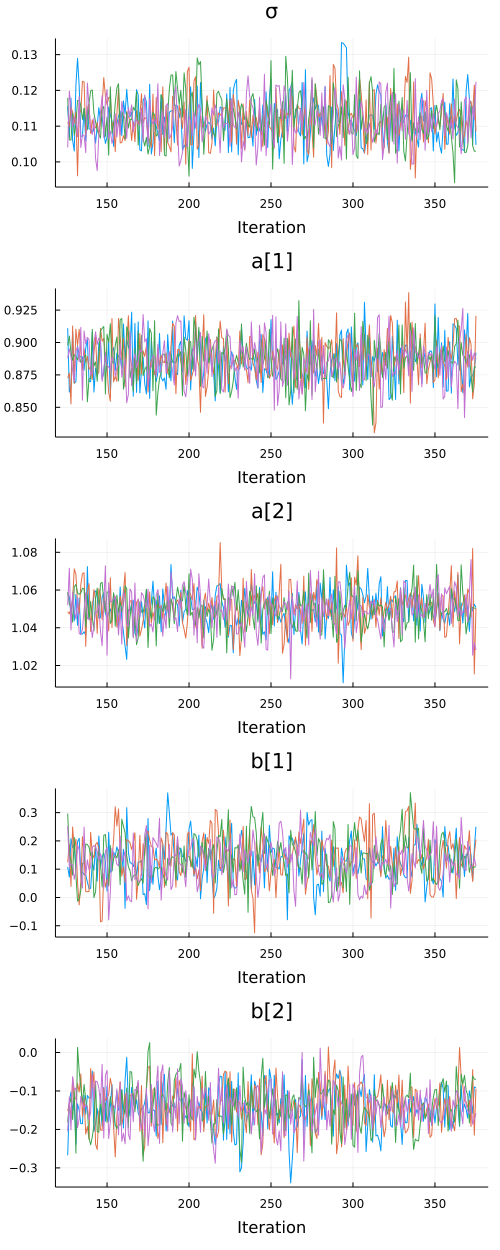

In [38]:
traceplot(m9_1)

Code 9.21

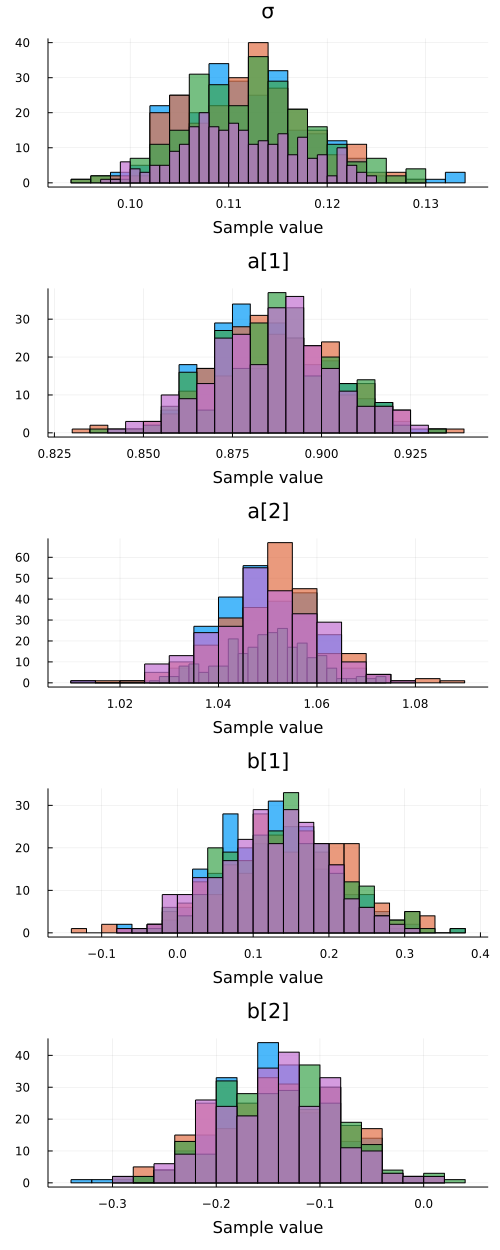

In [39]:
histogram(m9_1)

# 9.5 Care and feeding of your Markov chain

Code 9.22

To make it diverging with Turing, was needed to increase exp() argument.

In [41]:
Random.seed!(1)
y = [-1., 1.]

@model function model_m9_2(y)
    α ~ Normal(0, 1000)
    σ ~ Exponential(1/0.0001)
    y ~ Normal(α, σ)
end

m9_2 = sample(model_m9_2(y), NUTS(), 1000)
m9_2_df = DataFrame(m9_2);

Code 9.23

In [42]:
precis(m9_2_df)

┌───────┬──────────────────────────────────────────────────────────┐
│ param │     mean      std      5.5%      50%    94.5%  histogram │
├───────┼──────────────────────────────────────────────────────────┤
│     α │ -48.8262  419.866  -770.196  -5.1478  420.247  ▁▁▁█▇▁▁▁▁ │
│     σ │  741.106  2057.38    7.3159  112.992  3381.03   █▁▁▁▁▁▁▁ │
└───────┴──────────────────────────────────────────────────────────┘


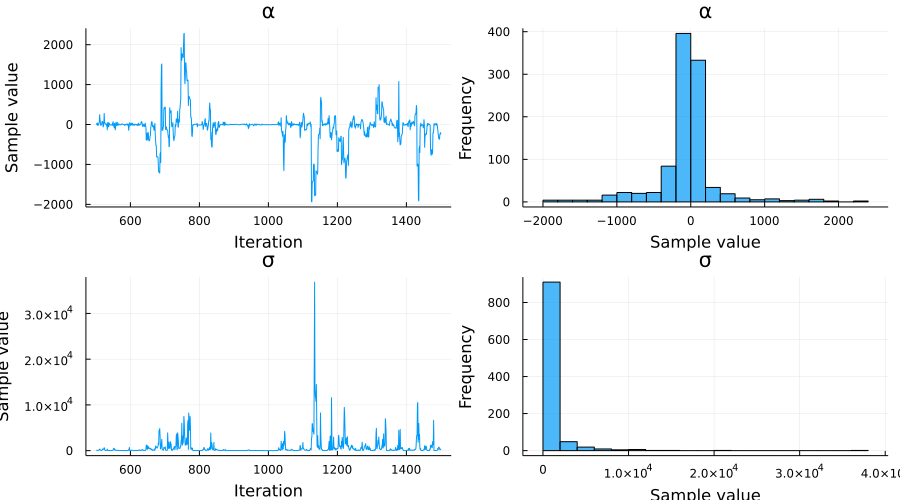

In [43]:
plot(
    traceplot(m9_2),
    histogram(m9_2),
    size=(900, 500)
)

Code 9.24

In [44]:
Random.seed!(2)

@model function model_m9_3(y)
    α ~ Normal(1, 10)
    σ ~ Exponential(1)
    y ~ Normal(α, σ)
end

m9_3 = sample(model_m9_3(y), NUTS(), 1000)
m9_3_df = DataFrame(m9_3)
precis(m9_3_df)

┌───────┬─────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%     50%   94.5%      histogram │
├───────┼─────────────────────────────────────────────────────────┤
│     α │ -0.0271  1.2576  -1.9354  0.0051  1.9253   ▁▁▁▁▃██▂▁▁▁▁ │
│     σ │  1.5607  0.8481   0.6739  1.3216  3.1969  ▁██▅▃▂▂▁▁▁▁▁▁ │
└───────┴─────────────────────────────────────────────────────────┘


Code 9.25

In [45]:
Random.seed!(41)
y = rand(Normal(), 100);

Code 9.26

In [46]:
Random.seed!(384)

@model function model_m9_4(y)
    a1 ~ Normal(0, 1000)
    a2 ~ Normal(0, 1000)
    σ ~ Exponential(1)
    μ = a1 + a2
    y ~ Normal(μ, σ)
end

m9_4 = sample(model_m9_4(y), NUTS(), 1000)
m9_4_df = DataFrame(m9_4)
display(precis(m9_4_df))
ess_rhat(m9_4)

nothing

┌───────┬────────────────────────────────────────────────────────────┐
│ param │     mean      std      5.5%      50%    94.5%    histogram │
├───────┼────────────────────────────────────────────────────────────┤
│    a1 │   456.99  470.545  -294.346  438.358  1168.57  ▂▄▅▅█▄▇█▄▂▁ │
│    a2 │ -456.896   470.55  -1168.46  -438.29  294.303  ▁▂▄█▇▄█▅▅▄▂ │
│     σ │   1.0548   0.0603    0.9529   1.0545   1.1497      ▂▄██▅▂▁ │
└───────┴────────────────────────────────────────────────────────────┘


ESS
  parameters       ess      rhat   ess_per_sec 
      Symbol   Float64   Float64       Float64 

          a1    2.3742    2.2858        0.3029
          a2    2.3742    2.2857        0.3030
           σ   20.3798    1.0107        2.6005


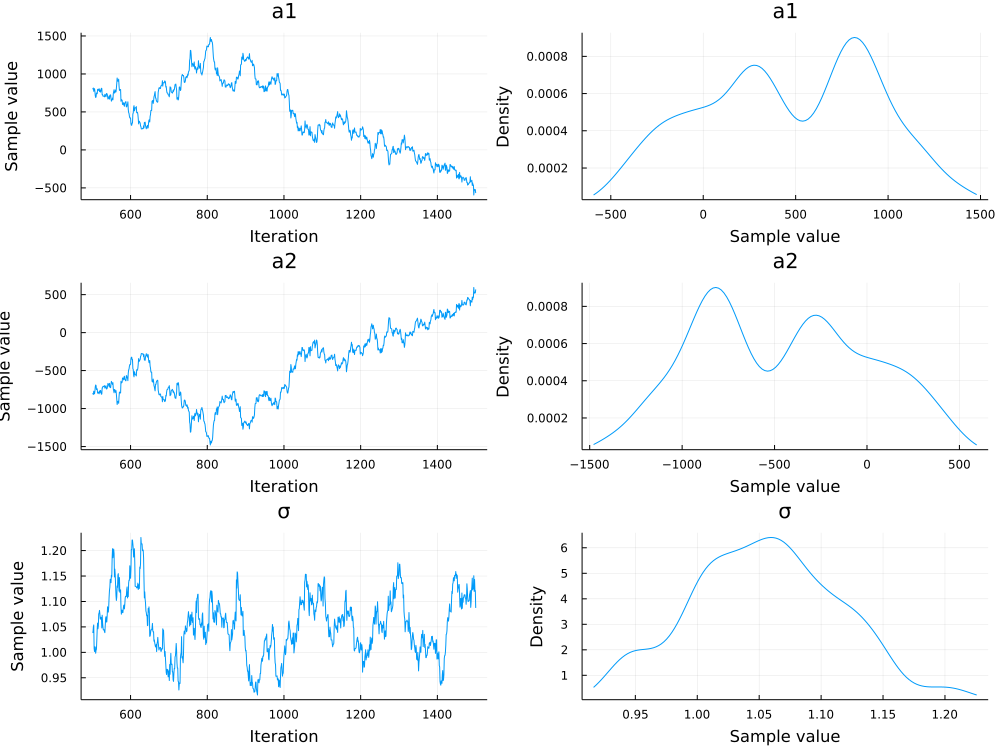

In [47]:
plot(m9_4)

Code 9.27

In [48]:
Random.seed!(384)

@model function model_m9_5(y)
    a1 ~ Normal(0, 10)
    a2 ~ Normal(0, 10)
    σ ~ Exponential(1)
    μ = a1 + a2
    y ~ Normal(μ, σ)
end

m9_5 = sample(model_m9_5(y), NUTS(), 1000)
m9_5_df = DataFrame(m9_5)
display(precis(m9_5_df))
ess_rhat(m9_5)

nothing

┌───────┬─────────────────────────────────────────────────────────┐
│ param │    mean     std      5.5%      50%    94.5%   histogram │
├───────┼─────────────────────────────────────────────────────────┤
│    a1 │  0.5891  6.9422  -10.1509   0.5734  12.3176   ▁▂▅██▅▃▁▁ │
│    a2 │ -0.4926  6.9428  -12.2104  -0.4543   10.313   ▁▁▃▅██▅▂▁ │
│     σ │  1.0728  0.0756    0.9592   1.0699   1.2087  ▁▂▄██▇▃▂▁▁ │
└───────┴─────────────────────────────────────────────────────────┘


ESS
  parameters        ess      rhat   ess_per_sec 
      Symbol    Float64   Float64       Float64 

          a1   234.4698    1.0029      105.8555
          a2   233.7228    1.0029      105.5182
           σ   439.3936    1.0000      198.3718


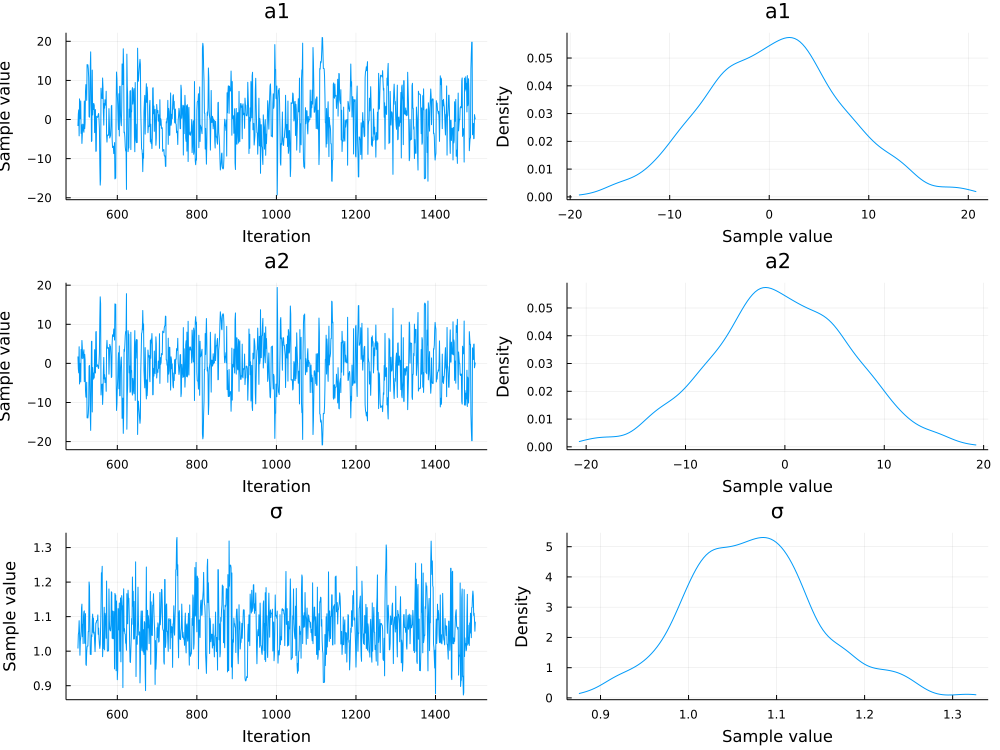

In [49]:
plot(m9_5)